### Importamos librerias

In [1]:
import pandas as pd                                   #Dataframe
from sklearn.svm import SVC                           #Support Vector Machines
from sklearn.ensemble import RandomForestClassifier   #Random Forest 
from sklearn.linear_model import LogisticRegression   #Regresion Lineal
from sklearn.model_selection import GridSearchCV      #Grid Search
from sklearn.metrics import confusion_matrix          #Matriz de confusion
import matplotlib.pyplot as plt                       #Graficas
import seaborn as sns                                 #Graficas Estadisticas
import warnings                                       #Advertencias
warnings.simplefilter("ignore")                       #Codigo para quitar advertencias

### Se carga el dataset

In [3]:
datasets = pd.read_excel ('mttoMetalitec-v2.xlsx')   #Se carga mediante pandas el dataset
datasets.head()                                      #Se muestran las primeras lineas del dataset

,Fecha,Operador,Presion Aire (PSI),Presion Neumatica (PSI),Corriente (Ampers),Presion Cilindro Longitudinal (PSI),Presion Cilindro Transversal (PSI),Fallo Linea,Fallo Electrico,Fallo Suministro,Mantenimiento Correctivo
0,2018-01-01,Cesar Contreras Martinez,298,315,153,139,302,0,0,0,0
1,2018-01-01,Claudio Perez Rodriguez,310,316,148,155,286,0,0,0,0
2,2018-01-02,Marco Adrian Gomez,313,290,163,168,291,0,0,0,0
3,2018-01-02,Omar Balderas Perez,292,303,189,156,312,0,0,0,0
4,2018-01-03,Gerardo Romero Alvarado,304,286,174,143,285,0,0,1,1


In [4]:
# Creación de los valores X,Y
X = datasets.iloc[:, [2,3,4,5,6]].values
y = datasets.iloc[:, 10].values

### Grid search

In [5]:
gridsearchlist=[] #lista para guardar resultados del gridsearch

In [6]:
# Grid search para SVC
param_grid = {'kernel': ['linear','sigmoid', 'rbf'],
              'C': [1.0,10.0],
              'gamma': ['scale','auto']}

base_clf=SVC()

grid_search=GridSearchCV(base_clf, param_grid, cv=5)
grid_search.fit(X,y)
for rank, params in zip(grid_search.cv_results_['rank_test_score'], grid_search.cv_results_['params']):
    if rank==1:
        print("SVC", rank, params)
        gridsearchlist.append(["SVC", rank, params])
    else:
        continue

SVC 1 {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}


In [7]:
# Grid search para RFC
param_grid = {'criterion' : ['gini', 'entropy', 'log_loss'],
              'max_depth': [5, 10],
              'max_features' : ['sqrt','log2']}

base_clf=RandomForestClassifier()

grid_search=GridSearchCV(base_clf, param_grid, cv=5)
grid_search.fit(X,y)
for rank, params in zip(grid_search.cv_results_['rank_test_score'], grid_search.cv_results_['params']):
    if rank==1:
        print("RF", rank, params)
        gridsearchlist.append(["RF", rank, params])
    else:
        continue

RF 1 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt'}


In [8]:
# Grid search para LR
param_grid = {'penalty': ['l1','l2','elasticnet'],
              'solver' : ['lbfgs', 'liblinear', 'sag'],
              'multi_class': ['auto', 'ovr', 'multinomial']}

base_clf=LogisticRegression()

grid_search=GridSearchCV(base_clf, param_grid, cv=5)
grid_search.fit(X,y)
for rank, params in zip(grid_search.cv_results_['rank_test_score'], grid_search.cv_results_['params']):
    if rank==1:
        print("LR", rank, params)
        gridsearchlist.append(["LR", rank, params])
    else:
        continue

LR 1 {'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}


In [10]:
#Se imprime la lista con los mejores hiperparametros
gridsearchlist

[['SVC', 1, {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}],
 ['RF', 1, {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt'}],
 ['LR', 1, {'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}]]

### Selección de datos basada en proporción

In [11]:
# Seleccionar el algoritmo para clasificar

classifier1=SVC(C=10.0, gamma= 'scale', kernel= 'rbf')
classifier2=RandomForestClassifier(criterion= 'gini', max_depth=10,  max_features= 'sqrt')
classifier3=LogisticRegression(multi_class= 'multinomial',penalty='l2', solver= 'lbfgs')

In [12]:
def repeticion (classifier):    
    # Se normalizan los datos
    from sklearn import preprocessing
    from sklearn.metrics import accuracy_score
    import numpy as np

    # Se deben realizar repeticiones del algoritmo para observar la variabilidad del algoritmo con los datos
    from sklearn.model_selection import train_test_split
    N_REPETITIONS=50

    # lista para guardar el accuracy
    acc=[]

    for i in range(N_REPETITIONS):
      # Seleccion del conjunto de datos estratificada
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

      # Se normalizan los datos
      min_max_scaler = preprocessing.MinMaxScaler()
      X_train = min_max_scaler.fit_transform(X_train)
      X_test = min_max_scaler.transform(X_test)

      # Se entrena el clasificador
      classifier.fit(X_train, y_train)

      # Se evalua el modelo
      y_pred=classifier.predict(X_test)

      # Se encuentra la precision (accuracy)
      acc.append(accuracy_score(y_test, y_pred))

    return (np.mean(np.array(acc)),np.std(np.array(acc)), y_test, y_pred)

In [13]:
#Se ejecutan las repeticiones para cada clasificador
resultadoSVM=repeticion(classifier1)
resultadoRF =repeticion(classifier2)
resultadoLR =repeticion(classifier3)

In [15]:
print("Clasificador      Resultado      Desviacion estandar", 
      "\nSVM:      ",resultadoSVM[0], resultadoSVM[1],
      "\nRF:       ",resultadoRF[0], resultadoRF[1],
      "\nLR:       ",resultadoLR[0], resultadoLR[1])
y_testSVM,y_predSVM = resultadoSVM[2],resultadoSVM[3]
y_testRF, y_predRF  = resultadoRF[2],resultadoRF[3]
y_testLR, y_predLR  = resultadoLR[2],resultadoLR[3]

Clasificador      Resultado      Desviacion estandar 
SVM:       0.9686774193548389 0.005762287238099126 
RF:        0.9884516129032259 0.003915868620772522 
LR:        0.894483870967742 0.005008733267904315


[Text(0.5, 23.52222222222222, 'Actual'),
 Text(50.722222222222214, 0.5, 'Predicted'),
 Text(0.5, 1.0, 'Support Vector Machines')]

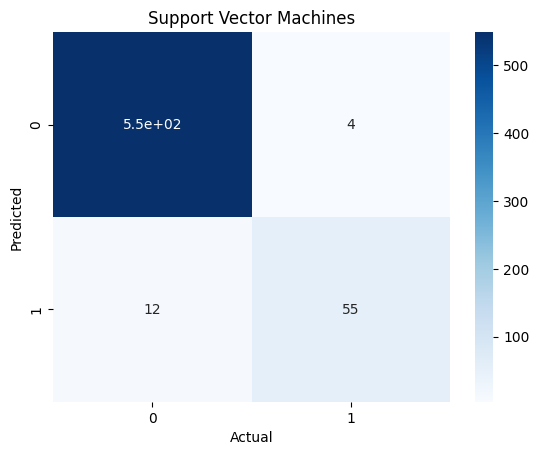

In [16]:
ax = sns.heatmap(confusion_matrix(y_testSVM, y_predSVM), cmap="Blues", annot=True)
ax.set(xlabel="Actual",ylabel="Predicted",title="Support Vector Machines")

[Text(0.5, 23.52222222222222, 'Actual'),
 Text(50.722222222222214, 0.5, 'Predicted'),
 Text(0.5, 1.0, 'Random Forest')]

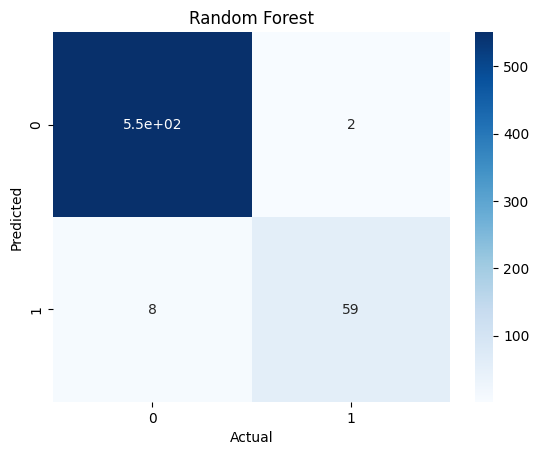

In [17]:
ax = sns.heatmap(confusion_matrix(y_testRF, y_predRF), cmap="Blues", annot=True)
ax.set(xlabel="Actual",ylabel="Predicted",title="Random Forest")

[Text(0.5, 23.52222222222222, 'Actual'),
 Text(50.722222222222214, 0.5, 'Predicted'),
 Text(0.5, 1.0, 'Logistic Regression')]

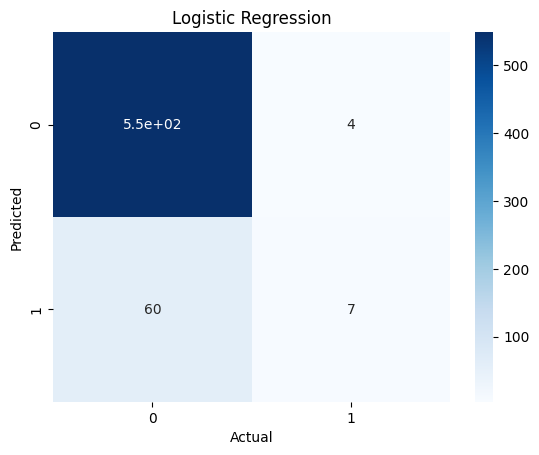

In [18]:
ax = sns.heatmap(confusion_matrix(y_testLR, y_predLR), cmap="Blues", annot=True)
ax.set(xlabel="Actual",ylabel="Predicted",title="Logistic Regression")